# <font color='red'>Clustering Assignment 

**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Please check [clustering assignment helper functions](https://drive.google.com/file/d/1V29KhKo3YnckMX32treEgdtH5r90DIjU/view?usp=sharing) notebook before attempting this assignment.**

*  Read graph from the givenmovie_actor_network.csv (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. [Refer >Clustering_Assignment_Reference.ipynb]

* Split the dense representation into actor nodes, movies nodes.(Write you code in def data_split())


# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors 

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in  def cost1() )<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in  def cost2() )<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies 


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in  def cost1() )<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in  def cost2() )<br>


**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

# Data Loading and Pre processing

<br>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install networkx==2.3 stellargraph -q

## Load Data

In [4]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph
from sklearn.cluster import KMeans

In [5]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignments/Clustering on Graph Dataset/movie_actor_network.csv', index_col=False, names=['movie','actor'])

## Create Graph and gensim

In [6]:
edges = [tuple(x) for x in data.values.tolist()]

In [7]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [8]:
A = list(nx.connected_component_subgraphs(B))[0]

In [9]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


In [10]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [11]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [12]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [13]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [14]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

## Split Data

In [15]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes

    for i in range(len(node_ids)):
      if node_targets[i] == 'actor':
        actor_nodes.append(node_ids[i])
        actor_embeddings.append(node_embeddings[i])
      else:
        movie_nodes.append(node_ids[i])
        movie_embeddings.append(node_embeddings[i])


    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings


In [16]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids,node_targets,node_embeddings)

actor_nodes = np.array(actor_nodes)
movie_nodes = np.array(movie_nodes)
actor_embeddings = np.array(actor_embeddings)
movie_embeddings = np.array(movie_embeddings)

<font color='cyan'>Grader function - 1 

In [17]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Grader function - 2 

In [18]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

## Cost Functions

 Calculating cost1 

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [19]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    N = len(graded_graph.nodes())
    #connected_comps = list of sets
    connected_comps = list(nx.connected_components(graph))

    #largest connected Component
    temp_arr = list(map(lambda x : list(x), connected_comps))
    temp_arr.sort(key = lambda x : len(x),reverse = True)
    len_largest_cc = len(temp_arr[0])

    cost1= len_largest_cc/ (N*number_of_clusters)
    
    return cost1

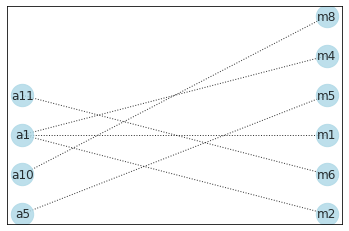

In [20]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0,label="actor") # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1,label="movie")
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

In [21]:
sub_graph1=nx.ego_graph(graded_graph,'a1')

In [22]:
sub_graph1.nodes()

NodeView(('m2', 'm4', 'a1', 'm1'))

<font color='cyan'>Grader function - 3 

In [23]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

 Calculating cost2 

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [24]:
graded_graph.node['a1']

{'bipartite': 0, 'label': 'actor'}

In [25]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    movieCount = 0
    degreeSum = 0
    for node in graded_graph.nodes():
      if graded_graph.node[node]["label"] == 'movie':
        movieCount += 1
      else:
        degreeSum += graded_graph.degree(node)

    cost2 = degreeSum / (movieCount*number_of_clusters)
    
    return cost2

<font color='cyan'>Grader function - 4 

In [26]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

# Task 1 : Group Similar Actors

In [27]:
from tqdm import tqdm
def maximize_cost(k_vals):
  cost_fns = []
  for k in tqdm(k_vals):
    clf = KMeans(n_clusters = k,random_state=10).fit(actor_embeddings)
    labels = clf.labels_

    cost_1, cost_2 = 0, 0

    for label_no in range(clf.n_clusters):
      # get all actors which belong to cluster with label = label_no
      sel_actors = actor_nodes[np.where(labels == label_no)[0]]
      
      #create graph from A
      G = nx.Graph()
      for act_node in sel_actors:
        temp_g = nx.ego_graph(A,act_node)
        G.add_nodes_from(temp_g.nodes) 
        G.add_edges_from(temp_g.edges()) 

      cost_1 += cost1(G, k)
      cost_2 += cost2(G, k)
    
    cost_fns.append(cost_1*cost_2)
  return k_vals[np.argsort(cost_fns)[-1]]

In [28]:
k_vals = [3, 5, 10, 30, 50, 100, 200, 500]
best_k = maximize_cost(k_vals)
print("Best value of k : ", best_k)

100%|██████████| 8/8 [00:57<00:00,  7.19s/it]

Best value of k :  3


In [29]:
best_model = KMeans(n_clusters = best_k,random_state=10).fit(actor_embeddings)
actor_cluster_labels = best_model.predict(actor_embeddings)

## TSNE Visualization


In [30]:
from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(actor_embeddings)

## Displaying Similar Actor Clusters

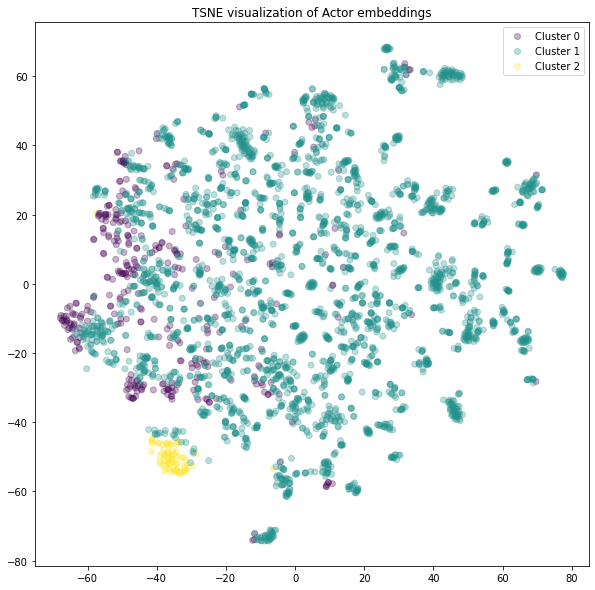

In [31]:
# Reference : https://stackoverflow.com/questions/17411940/matplotlib-scatter-plot-legend
# Add Scatter plot legend based on colors
import numpy as np

label_map = { l: i for i, l in enumerate(np.unique(actor_cluster_labels))}
node_colours = [ label_map[target] for target in actor_cluster_labels]

plt.figure(figsize=(10,10))
plt.axes().set(aspect="equal")
scatter = plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of Actor embeddings'.format(transform.__name__))
plt.legend(handles=scatter.legend_elements()[0], labels= ["Cluster "+str(label) for label in label_map.keys()])

plt.show()

# Task 2 : Group Similar Movies

In [32]:
from tqdm import tqdm
def maximize_cost(k_vals):
  cost_fns = []
  for k in tqdm(k_vals):
    clf = KMeans(n_clusters = k,random_state=10).fit(movie_embeddings)
    labels = clf.labels_

    cost_1, cost_2 = 0, 0

    for label_no in range(clf.n_clusters):
      # get all movies which belong to cluster with label = label_no
      sel_movies = movie_nodes[np.where(labels == label_no)[0]]
      
      #create graph from A
      G = nx.Graph()
      for mov_node in sel_movies:
        temp_g = nx.ego_graph(A,mov_node)
        G.add_nodes_from(temp_g.nodes) 
        G.add_edges_from(temp_g.edges()) 

      cost_1 += cost1(G, k)
      cost_2 += cost2(G, k)
    
    cost_fns.append(cost_1*cost_2)
  return k_vals[np.argsort(cost_fns)[-1]]

In [33]:
k_vals = [3, 5, 10, 30, 50, 100, 200, 500]
best_k = maximize_cost(k_vals)
print("Best value of k : ", best_k)

100%|██████████| 8/8 [00:27<00:00,  3.42s/it]

Best value of k :  3


In [34]:
best_model_movies = KMeans(n_clusters = best_k,random_state=10).fit(actor_embeddings)
movie_cluster_labels = best_model.predict(movie_embeddings)

## TSNE Visualization


In [35]:
from sklearn.manifold import TSNE
transform = TSNE 

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(movie_embeddings)

## Displaying Similar Movie Clusters

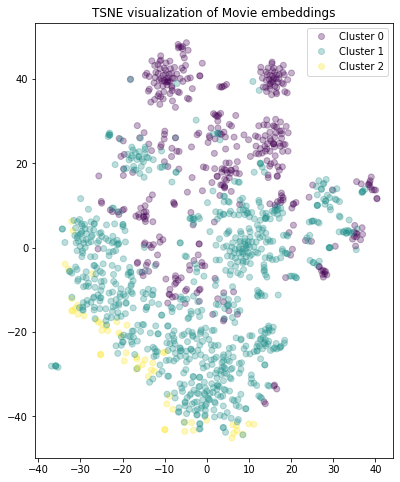

In [36]:
# Reference : https://stackoverflow.com/questions/17411940/matplotlib-scatter-plot-legend
# Add Scatter plot legend based on colors
import numpy as np

label_map = { l: i for i, l in enumerate(np.unique(movie_cluster_labels))}
node_colours = [ label_map[target] for target in movie_cluster_labels]

plt.figure(figsize=(10,8))
plt.axes().set(aspect="equal")
scatter = plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of Movie embeddings'.format(transform.__name__))
plt.legend(handles=scatter.legend_elements()[0], labels= ["Cluster "+str(label) for label in label_map.keys()])

plt.show()